<a href="https://colab.research.google.com/github/mwithgod3952/jh_Natural_language_processing/blob/main/%EC%B1%97%EB%B4%87_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***의도***
-	투자정보
-	가격 
-	거래량 
-	관련주

***개체명***

-	STO : 회사(주식)명
- MAR : 시장(비트코인, 코스피 코스닥 등...)
-	DAT : 날짜(오늘, 어제)
-	PUR : 질문의 목적
- VEL
-	YEA
-	MON
-	DAY
- WEK
-	검색에 반영할 조건
  *	IND:산업
  *	ACT:엑션
-	ABN: 분석목적(이상치 탐색, 분석결과 제시)
- EMO: 감정

# 설치구간

In [3]:
!pip install tensorflow==1.14.0
!pip install keras==2.2.4
!pip install tensorflow-gpu==1.14.0
!pip install git+https://www.github.com/keras-team/keras-contrib.git

!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
!git clone https://github.com/entelecheia/eKoNLPy.git
%cd eKoNLPy/
!python setup.py install
!pip install -U finance-datareader

     |████████████████████████████████| 109.3MB 50kB/s 
     |████████████████████████████████| 3.2MB 47.6MB/s 
     |████████████████████████████████| 491kB 43.3MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 317kB 6.3MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 377.1MB 37kB/s 
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-ib4le8hi
  Running command git clone -q h

---

# 기본설정

In [4]:
import requests
import re
import io
import random
import itertools

from bs4 import BeautifulSoup
import urllib.request
from urllib.request import urlopen, Request
from urllib.parse import quote

import pandas as pd
import numpy as np

from ekonlpy.tag import Mecab

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

The following packages were automatically installed and are no longer required:
  r-cran-covr r-cran-crosstalk r-cran-dt r-cran-htmlwidgets r-cran-later
  r-cran-lazyeval r-cran-promises r-cran-rex
Use 'apt autoremove' to remove them.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 161275 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 질문초안

### ***의도1 : 투자정보***

  - 얻고자 하는 투자정보에 대해 웹 뉴스기사 검색을 기반으로 자료를 취합하여 제곡하고자 한다. 

***투자정보 관련 질문 생성 단계***

    - 아이디어 : 블로그 글 크롤링 및 활용
    - 질문 관련 글 크롤링 

###### ***주식커뮤니티 토론방 내용에서 흰트얻기***

In [ ]:
# # 1-3 : 
# 출처 : https://www.stocker.kr/index.php?mid=discuss&page=1 (커뮤니티명 : STOCKER)

def crawling_comment(pages = 3):
  comment_df = pd.DataFrame(columns=('index', 'comment'))
  idx = 0
  for X in range(1, pages):
    url = f'https://www.stocker.kr/index.php?mid=discuss&page={X}'
    surf_url = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(surf_url, 'html.parser')
    sentences = soup.find_all('span', {'class':'ed title-link'})
    for sentence in range(len(sentences)):
      s = re.sub(r'[.,!<>/=?"\':;~()]', '', str(sentences[sentence]))
      cmt = re.sub('[a-zA-z]','',s)
      comment_df.loc[idx] = [idx, cmt]
      idx += 1
  return comment_df 

In [ ]:
# 마지막 페이지가 18페이지
comment_df = crawling_comment(pages=19)
comment_df = comment_df.drop('index', axis=1)

In [ ]:
comment_df.head()

In [4]:
from google.colab import files
comment_df.to_excel('commnet_dataset.xlsx', index=False)
files.download('commnet_dataset.xlsx')

---

###### ***주식송목 크롤링***

In [5]:
import FinanceDataReader as fdr

df_krx = fdr.StockListing('KRX')
stock_list = df_krx['Name'].tolist()

###### ***질물생성_1 (의도 :  투자정보)***

In [6]:
# 개체명 구성 : STO(주식명)

name = stock_list 

markets = ['비트코인', '코스피', '코스닥']
name.append(markets[0])
name.append(markets[1])
name.append(markets[2])

def question_invest_info_1(list = name):
  se_0 = []
  for n in list:
    s1 = n+' 투자관련 지식정보'
    s2 = n+' 최근 이슈'
    s3 = n+' 필수정보'
    s4 = n+' 트렌트 탐색'
    s5 = n+' 주식투자에 필요한 기사 알려줘'
    s6 = n+' 주식에 필요한 내용 알려줘'
    s7 = n+' 주식 관련 추천기사 알려줘'
    s8 = n+' 추천기사'
    s9 = n+' 추천뉴스'
    s10 = n+' 트렌드'
    s11 = n+' 트렌드 알려줘'
    s12 = n+'를 분석해주세요'
    s13 = n+' 분석해봐'
    s14 = n+' 인기있는 기사'
    s15 = n+'의 가장 핫한 이슈가 뭐야'
    s16 = n+'의 반드시 알아야 할 내용'
    s17 = n+' 트렌드 알려줘'
    s18 = n+' 인기있는 기사'
    s19 = n+'의 가장 핫한 이슈가 뭐야'
    s20 = n+'의 반드시 알아야 할 내용'
    s21 = n+' 소식'
    s22 = n+' 소식요약'
    s23 = n+'에 투자하기 위해 기업과 관련된 뉴스를 탐색해줄래'
    s24 = n+'에 투자하려고 하는데 실적정보를 알려줄래'
    s25 = n+'투자하는게 잘한 선택일까?'
    s26 = n+'에 대해 니 생각은 어때?'
    s27 = n+'주식 초보 기초정보'
    se_0 = se_0+[s1, s2, s3, s4, s5, s6, s6, s7, s8, s9, s10, s11, s12, s13, s15, s16, s17, s18, s19, s20, s21, s22, s23, s24, s25, s26, s27]
  return se_0

# 개체명 구성 : MAR, VEL
markets = ['비트코인', '코스피', '코스닥', '대형주', '중소형주', '중형주', '소형주']
stock_status = ['공매도', '배당금']

s_name = stock_status
m_name = markets

def question_invest_info_2(list_1 = m_name, list_2 = s_name):
  se_1 = []
  for n1 in list_1:
    for n2 in list_2:
        s1 = f'{n1}에서 {n2}현상이 지속될만한 금융상품 뉴스를 취합해줘'
        s2 = f'{n1}에서 {n2} 예상되는 주식뉴스를 취합해줘'
        s3 = f'{n1} {n2} 관련 뉴스 검색해줘'
        s4 = f'{n1} {n2} 분위기좀 알려줘'
        s5 = f'{n1} {n2} 계속 들썩거리니?'
        s6 = f'{n1} {n2} 상황이 어때?'
        se_1 = se_1+[s1, s2, s3, s5, s6]
  return se_1

# 개채명 구성 : MON, DAY, VEL
volatility = ['상승', '하락', '정체', '급등']
weeks = ['첫째주', '둘째주', '셋째주', '넷째주']

def question_invest_info_3(list_1 = stock_list):
  se_2 = []
  for stock in range(len(list_1)):
    name = list_1[stock]
    for v in volatility:
      s1 = f'{random.randint(1,12)}월 {random.randint(1,30)}일 {name} {v}관련 이슈 취합해줘'
      # print(s1)
      s2 = f'{random.randint(1,12)}월 {random.randint(1,30)}일 {name} {v}관련 자료'
      # print(s2)
      s3 = f'{random.randint(1,12)}월 {random.choice(weeks)} {name} {v}'
      # print(s3)
      se_2 = se_2+[s1, s2, s3]
  return se_2

###### Mecab 사전추가(의도 : 투자정보)

In [7]:
mecab = Mecab()

In [9]:
for s in stock_list:
  mecab.add_dictionary(s, 'NNG')
for m in markets:
  mecab.add_dictionary(m, 'NNG')
for t in stock_status:
  mecab.add_dictionary(t, 'NNG')
for w in weeks:
  mecab.add_dictionary(w, 'NNG')
for v in volatility:
  mecab.add_dictionary(v, 'NNG')
# for S in Sector:
#   mecab.add_dictionary(S, 'NNG')

In [10]:
cr_year = [X + '년' for X in [str(x) for x in list(range(1,11))]]
print(cr_year)
for y in cr_year:
  mecab.add_dictionary(y, 'NNG')
cr_month = [X + '월' for X in [str(x) for x in list(range(1,13))]]
print(cr_month)
for m in cr_month:
  mecab.add_dictionary(m, 'NNG')
cr_day = [X + '일' for X in [str(x) for x in list(range(1,32))]]
print(cr_day)
for d in cr_day:
  mecab.add_dictionary(d, 'NNG')


['1년', '2년', '3년', '4년', '5년', '6년', '7년', '8년', '9년', '10년']
['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']
['1일', '2일', '3일', '4일', '5일', '6일', '7일', '8일', '9일', '10일', '11일', '12일', '13일', '14일', '15일', '16일', '17일', '18일', '19일', '20일', '21일', '22일', '23일', '24일', '25일', '26일', '27일', '28일', '29일', '30일', '31일']


---

###### 사전추가로 해결되지 않는 회사이름에 대한 개체명 인식 방법 모색_2

    - 문장 1

In [11]:
q_invest_1_sample = question_invest_info_1(list = ['3s'])

samples_tokenized_invest_q1 = []
for q in q_invest_1_sample:
  samples_tokenized_invest_q1.append(mecab.morphs(q))

remove_object_name_f_se1 = [X for sublist in samples_tokenized_invest_q1 for X in sublist if X != '3s']
remove_object_name_f_se1[:10]  

['투자', '관련', '지식', '정보', '최근', '이슈', '필수', '정보', '트렌트', '탐색']

In [12]:
invest_info_1 = question_invest_info_1()

tokenized_sequences = []
label_sequences = []

for sample in invest_info_1:
  temp_sample = []
  tokenized_sample = mecab.morphs(sample) 
  tokenized_sequences.append(tokenized_sample)

  for word in tokenized_sample:
    z = []
    for i in markets:
      if i in word:
        z.append(i)

    if word in remove_object_name_f_se1:
      temp_sample.append('O')
    else:
      if 'B-STO' in temp_sample:
        temp_sample.append('I-STO')
      elif len(z) < 1:
        temp_sample.append('B-STO')
      else:
        temp_sample.append('B-MAR')
  label_sequences.append(temp_sample)        

In [13]:
q_df_invest_info_1 = pd.DataFrame()
q_df_invest_info_1['qeustion'] = invest_info_1
q_df_invest_info_1['results_tokenized'] = tokenized_sequences
q_df_invest_info_1['results_named_entity_recognition'] = label_sequences

In [14]:
q_df_invest_info_1.iloc[np.r_[200:201, len(q_df_invest_info_1)-1:len(q_df_invest_info_1)],:]

,qeustion,results_tokenized,results_named_entity_recognition
200,ARIRANG 200동일가중 트렌드 알려줘,"[ARIRANG200, 동일, 가중, 트렌드, 알려줘]","[B-STO, I-STO, I-STO, O, O]"
194885,코스닥주식 초보 기초정보,"[코스닥, 주식, 초보, 기초, 정보]","[B-MAR, O, O, O, O]"


    - 문장2

In [15]:
q_invest_2_sample = question_invest_info_2(['코스피'], ['공매도'])

samples_tokenized_invest_q2 = []
for q in q_invest_2_sample:
  samples_tokenized_invest_q2.append(mecab.morphs(q))

remove_object_name_f_se2 = [X for sublist in samples_tokenized_invest_q2 for X in sublist if X != '코스피' and X != '공매도']
remove_object_name_f_se2[:10]

['에서', '현상', '이', '지속', '될', '만', '한', '금융상품', '뉴스', '를']

In [16]:
invest_info_2 = question_invest_info_2()

tokenized_sequences = []
label_sequences = []

for sample in invest_info_2:
  temp_sample = []
  tokenized_sample = mecab.morphs(sample) 
  tokenized_sequences.append(tokenized_sample)

  for word in tokenized_sample:
    if word in remove_object_name_f_se2:
      temp_sample.append('O')
    else:
      if 'B-MAR' in temp_sample:
        temp_sample.append('B-VEL')
      else:
        temp_sample.append('B-MAR')
  label_sequences.append(temp_sample)        

In [17]:
q_df_invest_info_2 = pd.DataFrame()
q_df_invest_info_2['qeustion'] = invest_info_2
q_df_invest_info_2['results_tokenized'] = tokenized_sequences
q_df_invest_info_2['results_named_entity_recognition'] = label_sequences

In [18]:
q_df_invest_info_2.iloc[np.r_[0:1, len(q_df_invest_info_2)-1:len(q_df_invest_info_2)],:]

,qeustion,results_tokenized,results_named_entity_recognition
0,비트코인에서 공매도현상이 지속될만한 금융상품 뉴스를 취합해줘,"[비트코인, 에서, 공매도, 현상, 이, 지속, 될, 만, 한, 금융상품, 뉴스, ...","[B-MAR, O, B-VEL, O, O, O, O, O, O, O, O, O, O..."
69,소형주 배당금 상황이 어때?,"[소형주, 배당금, 상황, 이, 어때, ?]","[B-MAR, B-VEL, O, O, O, O]"


    - 문장3

In [19]:
q_invest_3_sample = ['11월 17일 3S 상승관련 이슈 취합해줘',
                     '11월 17일 3S 상승관련 자료',
                     '11월 첫째주 3S 상승']
samples_tokenized_invest_q3 = []
for q in q_invest_3_sample:
  samples_tokenized_invest_q3.append(mecab.morphs(q))

remove_object_name_f_se3 = [X for sublist in samples_tokenized_invest_q3 for X in sublist if X != '11월' and X != '17일' and X != '3S' and X != '상승' and X != '첫째주']
remove_object_name_f_se3

['관련', '이슈', '취합', '해', '줘', '관련', '자료']

In [20]:
invest_info_3 = question_invest_info_3()

tokenized_sequences = []
label_sequences = []

for sample in invest_info_3:
  temp_sample = []
  tokenized_sample = mecab.morphs(sample) 
  tokenized_sequences.append(tokenized_sample)

  for word in tokenized_sample:
    z1 = []
    for b in weeks:
      if b in word:
        z1.append(b)
    z2 = []
    if not '일' in word and not '월' in word and not '째주' in word: 
      if not word in markets:
          z2.append(word)        

    if word in remove_object_name_f_se3:
      temp_sample.append('O')
    else:
      if word in volatility:
        temp_sample.append('B-VEL')
      else:
        if word in markets:
          temp_sample.append('B-MAR')
        elif len(z1) < 1 and 'B-STO' in temp_sample:
          temp_sample.append('I-STO')
        elif len(z2) >= 1:
          temp_sample.append('B-STO')
        else:
          if len(z1) >= 1:
             temp_sample.append('B-WEK')
          else:
            if 'B-MON' in temp_sample:
              temp_sample.append('B-DAY')
            else:                           
              temp_sample.append('B-MON')
  label_sequences.append(temp_sample)

In [21]:
q_df_invest_info_3 = pd.DataFrame()
q_df_invest_info_3['qeustion'] = invest_info_3
q_df_invest_info_3['results_tokenized'] = tokenized_sequences
q_df_invest_info_3['results_named_entity_recognition'] = label_sequences

In [22]:
q_df_invest_info_3.iloc[np.r_[298:299, len(q_df_invest_info_3)-1:len(q_df_invest_info_3)],:]

,qeustion,results_tokenized,results_named_entity_recognition
298,7월 5일 ARIRANG 국채선물3년 급등관련 자료,"[7월, 5일, ARIRANG, 국채선물, 3년, 급등, 관련, 자료]","[B-MON, B-DAY, B-STO, I-STO, I-STO, B-VEL, O, O]"
86615,8월 첫째주 코스닥 급등,"[8월, 첫째주, 코스닥, 급등]","[B-MON, B-WEK, B-MAR, B-VEL]"


###### 의도 투자정보에 대한 데이터프레임

In [29]:
df_invest_info_final = pd.concat([q_df_invest_info_1, q_df_invest_info_2, q_df_invest_info_3])
df_invest_info_final['intent'] = '투자정보'

,qeustion,results_tokenized,results_named_entity_recognition,intent
0,3S 투자관련 지식정보,"[3S, 투자, 관련, 지식, 정보]","[B-STO, O, O, O, O]",투자정보
1,3S 최근 이슈,"[3S, 최근, 이슈]","[B-STO, O, O]",투자정보
2,3S 필수정보,"[3S, 필수, 정보]","[B-STO, O, O]",투자정보
3,3S 트렌트 탐색,"[3S, 트렌트, 탐색]","[B-STO, O, O]",투자정보
4,3S 주식투자에 필요한 기사 알려줘,"[3S, 주식, 투자, 에, 필요, 한, 기사, 알려줘]","[B-STO, O, O, O, O, O, O, O]",투자정보
...,...,...,...,...
86611,1월 11일 코스닥 정체관련 자료,"[1월, 11일, 코스닥, 정체, 관련, 자료]","[B-MON, B-DAY, B-MAR, B-VEL, O, O]",투자정보
86612,11월 넷째주 코스닥 정체,"[11월, 넷째주, 코스닥, 정체]","[B-MON, B-WEK, B-MAR, B-VEL]",투자정보
86613,5월 19일 코스닥 급등관련 이슈 취합해줘,"[5월, 19일, 코스닥, 급등, 관련, 이슈, 취합, 해, 줘]","[B-MON, B-DAY, B-MAR, B-VEL, O, O, O, O, O]",투자정보
86614,1월 17일 코스닥 급등관련 자료,"[1월, 17일, 코스닥, 급등, 관련, 자료]","[B-MON, B-DAY, B-MAR, B-VEL, O, O]",투자정보


In [30]:
df_invest_info_final.to_csv('df_invest_info_final.csv', index=False)

### ***의도2 : 가격***

###### ***질물생성_1 (의도 :  가격정보)***

###### 보류문장

In [ ]:
# 개체명 구성 : STO, IND
Sector = df_krx.dropna(axis=0)['Sector'].dropna().tolist()
stock_name = df_krx.Name.tolist()

def question_invest_info_4(list_1 = Sector, list_2 = stock_name):
  se_4 = []
  for i in range(len(list_1)):
    n_sector = list_1[i].replace(" ","")
    n_sector = re.sub(r'[.,!<>/=?"\':;~()]', '', n_sector)
    s1 = f'{list_2[i]} {n_sector}의 미래 가치는?'
    s2 = f'{list_2[i]} {n_sector} 향후 전망'
    s3 = f'{list_2[i]} {n_sector} 발전 가능성'
    se_4 = se_4+[s1, s2, s3]
  return se_4    

In [ ]:
q_invest_4_sample = ['APS홀딩스 금융업의 미래 가치는?',
                     'APS홀딩스 금융업 향후 전망',
                     'APS홀딩스 금융업 발전 가능성']

samples_tokenized_invest_q4 = []
for q in q_invest_4_sample:
  samples_tokenized_invest_q4.append(mecab.morphs(q))

remove_object_name_f_se4 = [X for sublist in samples_tokenized_invest_q4 for X in sublist if X != 'APS홀딩스' and X != '금융업']
remove_object_name_f_se4

In [ ]:
invest_info_4 = question_invest_info_4()

invest_info_4_sentences_stock = []
invest_info_4_sentences_sector = []
for sentence in invest_info_4:
  # invest_info_4_sentences_stock.append(sentence.split(" ", 1)[0])
  invest_info_4_sentences_sector.append(sentence.split(" ", 1)[1])

tokenized_sequences_0 = []
label_sequences_0 = []
for sample in invest_info_4_sentences_sector:
  temp_sample = []
  tokenized_sample = mecab.morphs(sample) 
  tokenized_sequences_0.append(tokenized_sample)
  for word in tokenized_sample:
    if word in remove_object_name_f_se4:
      temp_sample.append('O')
    else:
      if 'B-IND' in temp_sample:
        temp_sample.append('I-IND')
      else:
        temp_sample.append('B-IND')
  label_sequences_1.append(temp_sample)


idx = 0
tokenized_sequences = []
label_sequences = []
for sample in invest_info_4:
  temp_sample = []
  tokenized_sample = mecab.morphs(sample) 
  tokenized_sequences.append(tokenized_sample)

  space_to_allocate_stock = len(tokenized_sample) - len(label_sequences_1)
  temp_sample = [['B-STO'], list(itertools.repeat('I-STO', space_to_allocate_stock -1))]
  temp_sample = sum(temp_sample,[])
  t = [temp_sample, label_sequences_1[idx]]
  temp_sample_new = sum(t, [])
  idx += 1
  label_sequences.append(temp_sample_new)

In [ ]:
q_df_invest_info_4 = pd.DataFrame()
q_df_invest_info_4['qeustion'] = invest_info_4
q_df_invest_info_4['results_tokenized'] = tokenized_sequences
q_df_invest_info_4['results_named_entity_recognition'] = label_sequences

---

###### passing

---

In [ ]:
names = stock_list

def question_generator(names):
    question = []
    for name in names:
        s1 = name+' 알려줘'
        s2 = name+'에 대해 알려줘'
        s3 = name+' 관련 뉴스 보여줘'
        s4 = name+' 기사 보여줘'
        s5 = name+' 주식투자에 필요한 기사 알려줘'
        s6 = name+' 주식에 필요한 내용 알려줘'
        s7 = name+' 주식 관련 추천기사 알려줘'
        s8 = name+' 추천기사'
        s9 = name+' 추천뉴스'
        s10 = name+' 트렌드'
        s11 = name+' 트렌드 알려줘'
        s12 = name+'를 분석해주세요'
        s13 = name+' 분석해봐'
        s14 = name+' 인기있는 기사'
        s15 = name+'의 가장 핫한 이슈가 뭐야'
        s16 = name+'의 반드시 알아야 할 내용'
        s17 = name+' 트렌드 알려줘'
        s18 = name+' 분석해봐'
        s19 = name+' 인기있는 기사'
        s20 = name+'의 가장 핫한 이슈가 뭐야'
        s21 = name+'의 반드시 알아야 할 내용'
        s22 = name+' 소식'
        s23 = name+' 소식 요약해줘'
        s24 = name+' 요약해줘'
        s25 = name+' 투자에 필요한 기사'
        s26 = name+' 투자에 알아야 할 기사'
        s27 = name+' 투자에 알아야 할 뉴스'
        s28 = name+' 필수내용'
        s29 = name+' 주요기사'
        s30 = name+' 주요뉴스'
        s31 = name+' 사업개요 알려줘'
        s32 = name+' 사업 개요가 궁금해'
        s33 = name+'를 분석해줘'
        s34 = name+' 분석'
        s35 = name+' 요약해줘'
        s36 = name+' 요약해주세요'
        s37 = name+' 요약해봐'
        s38 = name+'를 분석해주세요'
        s39 = name+' 분석해봐'
        s40 = name+' 요약'
        s41 = name+' 개요'
        s42 = name+'에 대해 개요를 알려줘봐'
        s43 = name+'의 사업 개요는 뭐야'
        s44 = name+'에 대해서 요약해줘'
        s45 = name+' 기업 개요를 알려줘'
        s46 = name+' 기업 개요를 말해봐'
        s47 = name+'의 개요는 뭘까'
        s48 = name+'의 개요가 뭐야?'
        s49 = name+'사업 개요를 요약해줘'
        s50 = name+'에 대해서 요약해줘'
        s51 = name+'를 요약 해줘'
        s52 = name+'를 요약 분석한다면?'

        question = question+[s1, s2, s3, s4, s5, s6, s6, s7, s8, s9, s10, s11, s12, s13, s15, s16, s17, s18, s19, s20, s21, s22, s23, s24, s25, s26, s27, s28, s29, s30,
                             s31, s32, s33, s34, s35, s36, s37, s38, s39, s40, s41, s42, s43, s44, s45, s46, s47, s48, s49, s50, s51, s52]
    return question

analysis = question_generator(names)

In [ ]:
analysis[len(analysis) - 5:len(analysis)]

['힘스 투자에 알아야 할 기사', '힘스 투자에 알아야 할 뉴스', '힘스 필수내용', '힘스 주요기사', '힘스 주요뉴스']

In [ ]:
from ekonlpy.tag import Mecab
mecab = Mecab()

In [ ]:
# tokenized_test_result = []
# for sample_keyword_question in analysis:
#   tokenized_test_result.append(mecab.morphs(sample_keyword_question))

In [ ]:
analysis_data = {'question' : analysis, 'intent' : ['투자정보']*len(analysis)}
analysis_df = pd.DataFrame(similarity_data, columns=('question', 'intent'))

중략

.

.

.


---

# 크로링 및 모델학습 구간

***네이버 기사 및 링크 크롤링 테스트***

In [ ]:
import requests
import re

import FinanceDataReader as fdr
from bs4 import BeautifulSoup
import urllib.request
from urllib.request import urlopen, Request
from urllib.parse import quote

import pandas as pd
import numpy as np

# ==============================================================================

def get_news(stock_name, pages):

  stock_ns_df = pd.DataFrame(columns = ('Title', 'Adress'))
  idx = 0

  url_query = quote(stock_name)

  for pg_rng in range(pages):
    url = 'https://search.naver.com/search.naver?where=news&sm=tab_jum&query=' + url_query + str('&start=' + str(pg_rng * 10 + 1))

    surf_url = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(surf_url, 'html.parser')
    links = soup.find_all('div', {'class':'news_wrap api_ani_send'})
    titls = soup.find_all('a', {'class':'news_tit'})
    dates = soup.find_all('span', {'class':'info'})

    for i in range(len(links)):
      news_url = links[i].find('a').get('href')
      news_titl = titls[i].get('title')

      stock_ns_df.loc[idx] = [news_titl, news_url]
      idx += 1

  return stock_ns_df 

In [ ]:
comp_list_1 = ['코콤',
             '에스넷',
             '상지카일홈',
             '현대통신',
             '코맥스',
             '에스원',
             'HDC아이콘트롤스',
             '유양디앤유',
             '경동나비엔',
             '피에스텍',
             '포스코ICT',
             '누리텔레콤',
             '옴니시스템',
             '현대리바트',
             '위닉스',
             '엠젠플러스',
             'GS건설',
             'LG전자',
             '삼성전자',
             'Sk텔레콤',
             'KT',
             'LG유플러스']

df_list = []
for crawling_by_cny in range(len(comp_list_1)):
  sub_df = get_news(comp_list[crawling_by_cny], 10)
  df_list.append(sub_df)

In [ ]:
df_result = pd.concat(df_list, axis=0)
df_result.to_excel('labeling_test.xlsx', index=False)

---

***재무재표 크롤링 Test***

In [ ]:
# symbol crawling
df_krx = fdr.StockListing('KRX')
df_symbol = df_krx[['Symbol', 'Name']]
df_symbol.tail()

,Symbol,Name
7010,000547,흥국화재2우B
7011,000545,흥국화재우
7012,003280,흥아해운
7013,037440,희림
7014,238490,힘스


In [ ]:
def crawling_financial_statement(company_name):
  symbol_idx = np.where(df_symbol.Name == company_name)[0][0]
  symbol = df_symbol.Symbol[symbol_idx]

  URL = f"https://finance.naver.com/item/main.nhn?code={symbol}"

  statement_info = requests.get(URL)
  html = statement_info.text
  soup = BeautifulSoup(html, 'html.parser')
  finance_html = soup.select('div.section.cop_analysis div.sub_section')[0]

  th_data = [item.get_text().strip() for item in finance_html.select('thead th')]
  annual_date = th_data[3:7]
  quarter_date = th_data[7:13]
  finance_index = [item.get_text().strip() for item in finance_html.select('th.h_th2')][3:]
  finance_data = [item.get_text().strip() for item in finance_html.select('td')]
  finance_data = np.array(finance_data)
  finance_data.resize(len(finance_index), 10)
  finance_date = annual_date + quarter_date

  finance = pd.DataFrame(data=finance_data[0:,0:], index=finance_index, columns=finance_date)
  return finance.iloc[:, :4]

In [ ]:
crawling_financial_statement('현대통신')

,2018.12,2019.12,2020.12,2021.12(E)
매출액,"1,273","1,046","1,037",
영업이익,201,105,86,
당기순이익,170,107,91,
영업이익률,15.78,10.04,8.32,
순이익률,13.39,10.20,8.81,
ROE(지배주주),25.22,13.60,10.89,
부채비율,47.86,33.92,25.62,
당좌비율,146.69,178.32,171.73,
유보율,"1,672.26","1,852.01","2,014.14",
EPS(원),"1,977","1,236","1,059",


.

.

.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Intent_jh.xlsx to Intent_jh.xlsx


In [ ]:
import io
df_intent = pd.read_excel(io.BytesIO(uploaded['Intent_jh.xlsx']))

In [ ]:
df_intent = df_intent[['Title', 'Adress']]
df_intent.columns = ['article', 'intent']
df_intent.tail()

,article,intent
2194,"LGU+ 온라인몰 '유샵', 국내 최초 자급제폰 개통 원스톱 서비스",전략
2195,"SK텔레콤·LG유플러스, 상승에 급등으로 훨훨…SK텔레콤 6% 급등 이어 LG유플러...",주가전망
2196,"디즈니+, KT·LG U+와 3분기 상륙.. 미디어 업계 분주",시장전망
2197,"LG유플러스, ESG 경영 강화 위해 모니터링 시스템 구축",사업확장
2198,"LGU+ 황현식, 100개 국사에 에너지 모니터링 시스템 구축",사업확장


In [ ]:
df_intent = df_intent.dropna(how='any', axis=0)
df_intent.isnull().values.any()

False

In [ ]:
# df_intent.intent.value_counts()

In [ ]:
error = ['주가전망', '전력', '주가정망']
for i in range(3):
  df_intent = df_intent[df_intent.intent != error[i]]

In [ ]:
df_intent.intent.value_counts()

주식전망    123
전략      100
홍보       97
사업확장     83
시장전망     37
기타       32
매출       21
Name: intent, dtype: int64

---

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The following packages were automatically installed and are no longer required:
  r-cran-covr r-cran-crosstalk r-cran-dt r-cran-htmlwidgets r-cran-later
  r-cran-lazyeval r-cran-promises r-cran-rex
Use 'apt autoremove' to remove them.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 161272 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
import pandas as pd
import numpy as np
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
okt = Okt()

X_train = []
for sentence in df_intent.article:
    temp_X = []
    temp_X = okt.morphs(sentence)
    X_train.append(temp_X)

In [ ]:
X_train[:3]

[['주', '총', '통해', '살펴본', '조명', '상', '장사', ',', '위기', '탈출', '전략', '은'],
 ['김기훈', '코콤', '포터', '노벨', '리', '대표', ',', '한국', 'PR', '기업', '협회장', '선출'],
 ['코콤', ',', '비행기', '지', '통합', '관제', '체계', '구축', '사업', '수주']]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)

In [ ]:
X_train[:3]

[[103, 319, 320, 594, 595, 596, 597, 1, 408, 176, 598, 150],
 [599, 177, 600, 601, 409, 410, 1, 116, 602, 64, 603, 604],
 [177, 1, 605, 117, 321, 411, 606, 65, 15, 253]]

In [ ]:
print(tokenizer.word_index)

{',': 1, "'": 2, '통신': 3, 'kt': 4, '현대': 5, '카일': 6, '룸': 7, '상지': 8, '에스': 9, '넷': 10, 'lg': 11, '유플러스': 12, '"': 13, '…': 14, '사업': 15, '-': 16, '서비스': 17, '시스템': 18, '·': 19, '디지털': 20, '[': 21, '+': 22, 'b': 23, ']': 24, '한': 25, '현재': 26, '주가': 27, '헬': 28, '스케': 29, '어': 30, '확대': 31, '교육': 32, 'vi': 33, '발동': 34, '바이오': 35, '에': 36, '로': 37, '협력': 38, '‘': 39, '주식': 40, '와': 41, '테라': 42, '젠': 43, 'lgu': 44, '개통': 45, '과': 46, '빅데이터': 47, '’': 48, '2': 49, '발굴': 50, '돌봄': 51, '+,': 52, '맞': 53, '손': 54, '상승': 55, '용산구': 56, '그룹': 57, '아이': 58, '오피스텔': 59, '시작': 60, '제': 61, 'm': 62, '온라인': 63, '기업': 64, '구축': 65, '정보': 66, '출시': 67, '위': 68, '대': 69, '헬스': 70, '패스': 71, '원스톱': 72, '자급': 73, '폰': 74, '성장': 75, '학원': 76, '협회': 77, '들': 78, '솔루션': 79, '규모': 80, '과징금': 81, 'sk': 82, 'kmac': 83, '6월': 84, '시장': 85, '매출': 86, '관리': 87, '코로나': 88, '원': 89, '개발': 90, '분양': 91, '유': 92, '4월': 93, '스마트': 94, '기반': 95, '“': 96, '도입': 97, '도': 98, '증권': 99, "',": 100, '형': 101, '전일': 102, '

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


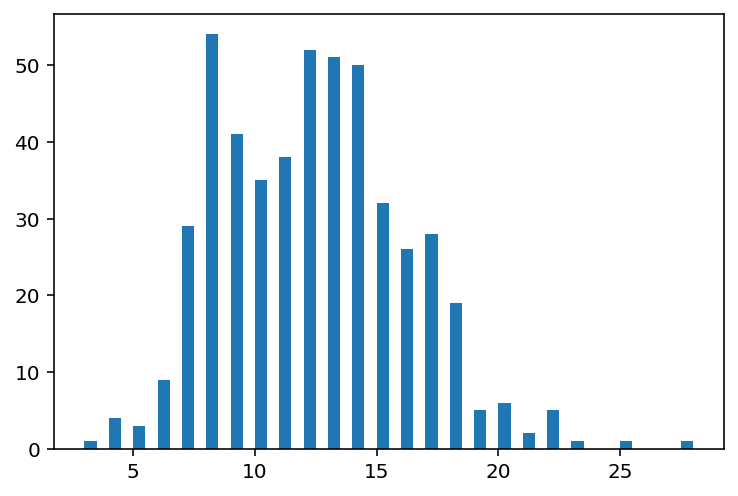

In [ ]:
plt.hist([len(x) for x in X_train], bins = 50)
plt.show()

In [ ]:
max_len = 25
X_train = pad_sequences(X_train, maxlen = max_len, padding='post')

***Label Encoding***

In [ ]:
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(df_intent['intent'])

y_train = idx_encode.transform(df_intent['intent'])

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print(label_idx)

{'기타': 0, '매출': 1, '사업확장': 2, '시장전망': 3, '전략': 4, '주식전망': 5, '홍보': 6}


In [ ]:
idx_label = {}
for key, value in label_idx.items():
    idx_label[value] = key

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 64))
model.add(LSTM(256))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_idx), activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs = 100, batch_size = 64)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
493/493 [==============================] - 2s 4ms/sample - loss: 1.8956 - acc: 0.2170
Epoch 2/100
493/493 [==============================] - 0s 508us/sample - loss: 1.7492 - acc: 0.2860
Epoch 3/100
493/493 [==============================] - 0s 484us/sample - loss: 1.5329 - acc: 0.3996
Epoch 4/100
493/493 [==============================] - 0s 487us/sample - loss: 1.4098 - acc: 0.4239
Epoch 5/100
493/493 [==============================] - 0s 520us/sample - loss: 1.2846 - acc: 0.5030
Epoch 6/100
493/493 [==============================] - 0s 514us/sample - loss: 1.2346 - acc: 0.4767
Epoch 7/100
493/493 [==============================] - 0s 491us/sample - loss: 1.1446 - acc: 0.5761
Epoch 8/100
493/493 [==============================] - 0s 524us/sample - loss: 1.0174 - acc: 0.6369
Epoch 9/100
493/493 [==============================] - 0s 686us/sample - loss: 0.8840 - acc: 0.6755
Epoch 10

In [ ]:
def article_processing(sentences):
    inputs = []
    for sentence in sentences:
        sentence = okt.morphs(sentence) 
        encoded = tokenizer.texts_to_sequences([sentence])
        inputs.append(encoded[0])
    padded_inputs = pad_sequences(inputs, maxlen=max_len, padding='post')
    return padded_inputs

In [ ]:
search_word = '현대통신'
results = get_news(search_word, 10)

input_sentence = article_processing(results['Title'].tolist())

In [ ]:
results.tail()

,Title,Adress
95,"현대통신, 20억 규모 자사주 취득 신탁계약 체결",http://www.heraldbiz.com/
96,투자주식 현대통신 주가 8일 현재 9400원,http://nbntv.co.kr/news/view/461720
97,4월 3일 현대통신 증권주식 0.00% 10350원,http://www.nbntv.co.kr/news/articleView.html?i...
98,"공정위, 아파트 마감재 입찰 담합 칼슨·현대통신·은광사 제재",http://www.koscaj.com
99,주가차트 현대통신 주가 5일 현재 9730원,http://nbntv.co.kr/news/view/457368


In [ ]:
prediction = np.argmax(model.predict(input_sentence), axis=1)
print(prediction)

[6 6 6 5 3 5 5 3 5 5 5 3 5 5 5 5 5 5 5 5 2 5 5 6 5 5 5 3 0 0 6 4 5 5 5 5 5
 5 5 5 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 0 5 5 5 5 5 5 6 5 5 5 3 5 5 5 5 0 5 5
 5 5 5 5 5 5 5 5 5 5 5 0 5 5 5 5 5 5 5 5 5 4 5 5 3 5]


In [ ]:
prediction_results = []
for p in prediction:
  prediction_results.append(idx_label[p])

In [ ]:
from collections import Counter
class_rs = Counter(prediction_results)

In [ ]:
class_rs.most_common(1)

[('주식전망', 78)]

# 답변 초안

In [ ]:
idx_num = np.where(pd.DataFrame(prediction_results).iloc[:,0] == str(class_rs.most_common(1)[0][0]))[0].min()
issue = class_rs.most_common(1)[0][0]
recent_topic = results.iloc[idx_num,0]
recent_link = results.iloc[idx_num,1]

print(f'{search_word}에 대해 꼭 알아두셔야 할 핫이슈 키워드는 V{issue} 이고,') 
print(f'해당 이슈의 가장 최근 뉴스 "{recent_topic}"에대한 세부기사는 여기 -> {recent_link} 에서 확인할 수 있어요.')

df_statement = crawling_financial_statement(search_word).replace(',','', regex=True)
subst_rows = df_statement.iloc[:,2].astype('float64') - df_statement.iloc[:,1].astype('float64')  
if sum(subst_rows < 0) > 0:
  print("")
  print(f'어맛 어떠케해요! 이것도 꼭 알아두세요! {search_word}의 재무재표의 아래 항목들에서 최근 V감소 추세를 발견했어요')
  print("")
  for i in range(len(np.where(subst_rows < 0)[0])):
    print('  * ',subst_rows.index[np.where(subst_rows < 0)][i])
  else:
    print("") 

현대통신에 대해 꼭 알아두셔야 할 핫이슈 키워드는 V주식전망 이고,
해당 이슈의 가장 최근 뉴스 "[배당뉴스] 현대통신, 주당 350원 배당...시가배당률 4.3%"에대한 세부기사는 여기 -> http://www.itooza.com/common/iview.php?no=2021031211082445208 에서 확인할 수 있어요.

어맛 어떠케해요! 이것도 꼭 알아두세요! 현대통신의 재무재표의 아래 항목들에서 최근 V감소 추세를 발견했어요

  *  매출액
  *  영업이익
  *  당기순이익
  *  영업이익률
  *  순이익률
  *  ROE(지배주주)
  *  부채비율
  *  당좌비율
  *  EPS(원)
  *  PBR(배)



---

- 우선, 잡아본 질문 초안과, 답변 초안은 위와 같습니다.
        * 투자정보에 대한 질문을 하면 최근 100 기사를 크롤링 및 기사에 대한 인텐트를 예측하고 예측한 정보 중 가장 빈도수가 많은 부류의 가장 최근의 기사를 요약하여 전달합니다.
        * 더불어, 재무재표를 크롤링하여, 얻어낸 결과 중
        가장 최근 년도의 항목들의 값과 이전 년도의 항목들의 값의 차(-)의 결과값이 음수이 경우가 1개 이상인 경우에만, 
        '어맛 어떠케해요! 이것도 꼭 알아두세요! 현대통신의 재무재표의 아래 항목들에서 최근 V감소 추세를 발견했어요' 라는 메세지와 함께 해당 항목들을 확인시켜줍니다.
===============================================================================

  - 추가적으로 거래량, 가격 의 '어제' '오늘' 의 값을 요구하는 경우 해당 질문을 분별하여 제시하기
  - 거래량의 추세를 물어보는 경우, 선택 년도를 일력하라는 질문 후 Isolation Forest 혹은 SARIMA 를 통해 이상적인 값으 탐색하여 날짜와 함께 제시할 계획입니다.